# Tobacco area classification for Mozambique

# Install libraries

In [2]:
#!pip install sentinelsat

In [ ]:
#!pip install folium

In [ ]:
#!pip install shapely

In [ ]:
#!pip install rasterio

In [ ]:
#!pip install --upgrade earthpy

# Import required libraries

In [127]:
import sentinelsat
from sentinelsat import SentinelAPI
import geopandas as gpd
from osgeo import gdal
import georaster
import rasterio
import rasterio as rio
from rasterio import mask as msk
from rasterio import plot
from rasterio.plot import show
import folium 
import shapely
from shapely.geometry import MultiPolygon, Polygon
from sentinelsat.sentinel import SentinelAPI, read_geojson, geojson_to_wkt

import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.colors as mc

import earthpy.plot as ep
from matplotlib.colors import ListedColormap


from sklearn import cluster
import numpy as np

import random

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Accessing data

 we need to register a username in [Copernicus Open Access Hub](https://scihub.copernicus.eu/dhus/#/home) and note down your username and password and paste them here inside the code.

In [128]:
user = "Marcinclair" 
password = "Marcinclair" 
api = SentinelAPI(user, password, "https://scihub.copernicus.eu/dhus")

# Display the shapefile data as a map

In [154]:
def display_map(file, latitude, longitude):
    
    # latitude and logitude range for Malawi 
    # [-15.786111, 35.005833] --> center
    range_latitude_Malw = [-17, -9]
    range_longitude_Malw = [33, 36]
    
    # latitude and logitude range for Mozambique
    # [-13.2512161, 34.3015278] --> center
    range_latitude_Moz = [-26, -10]
    range_longitude_Moz = [32, 41]
    
    while (True):
        Country_Name = input("Enter the name of your chosen country : Malawi or Mozambique\n\n")
        if (Country_Name != "Malawi" and Country_Name != "Mozambique"):
            print("Country name don't match. Try the exact name: Malawi or Mozambique")
        else:
            if Country_Name == "Malawi":
                if ( range_latitude_Malw[0] <= latitude <= range_latitude_Malw[1] and range_longitude_Malw[0] <= longitude <= range_longitude_Malw[1]):
                    pass
                else:
                    raise ValueError("Your latitude or longitude don't match! Please try again.")

            elif Country_Name == "Mozambique":
                if ( range_latitude_Moz[0] <= latitude <= range_latitude_Moz[1] and range_longitude_Moz[0] <= longitude <= range_longitude_Moz[1]):
                    pass
                else:
                    raise ValueError("Your latitude or longitude don't match! Please try again.")
            
            M = folium.Map([latitude, longitude], zoom_start=5)
            folium.GeoJson(file).add_to(M)
            return M

### Display map 

In [155]:
#shapefile_Mozam_data1 = gpd.read_file("ShapeMozambique/MOZ_adm1.shp")

bounds_geojson = gpd.read_file("C:/Users/engelbert/Downloads/Ishango/Notebook/mapMozambique1.geojson")

# latitudeMozan = -18.665695
# longitudeMozan = 35.529562

lat_zambezia_Moz = -16.653909048999935
long_zambezia_Moz = 36.98368136900007

# latitudeMalw = -13.9621
# longitudeMalw = 33.7937

display_map(bounds_geojson, lat_zambezia_Moz, long_zambezia_Moz)

Enter the name of your chosen country : Malawi or Mozambique

Mozambique


In [374]:
# footprint = None
# for i in shapefile_Mozam_data1['geometry']:
#     footprint = i

For geojson file, specify a geometry here: http://geojson.io/

In [140]:
# search by polygon

path_geojson_file = "C:/Users/engelbert/Downloads/Ishango/Notebook/mapMozambique1.geojson"

footprint = geojson_to_wkt(read_geojson(path_geojson_file))

print (footprint)

GEOMETRYCOLLECTION(POLYGON((34.7827 -13.1758,35.9253 -14.6686,35.8813 -15.9402,35.2002 -17.1828,33.0908 -17.6859,32.6953 -21.4735,34.7168 -21.2689,34.5190 -19.7460,40.4077 -15.2842,40.1440 -11.7383,35.2222 -11.6953,34.7827 -13.1758)))


## Searching products

In [142]:
products = api.query(footprint,
                     date = ('20200901', '20210930'),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0, 60)
                    )

Querying products:   2%|1         | 100/6112 [00:00<?, ?product/s]

In [143]:
print(f"The number of products are : {len(products)}")

The number of products are : 6112


## Convert the result into pandas

In [81]:
# products_gdf = api.to_geodataframe(products)
# products_gdf_sorted = products_gdf.sort_values(['cloudcoverpercentage'], ascending=[True])
# products_gdf_sorted

In [438]:
products_gdf = api.to_geodataframe(products)
products_gdf.head(2)

title  \
4e330914-e2a5-47a6-9682-b15724c1c317  S2B_MSIL2A_20210429T075609_N0300_R035_T35LRD_2...   
125e6e43-1eb1-4c8c-82d2-69078e9b532a  S2B_MSIL2A_20210429T075609_N0300_R035_T36LTJ_2...   

                                                                                   link  \
4e330914-e2a5-47a6-9682-b15724c1c317  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
125e6e43-1eb1-4c8c-82d2-69078e9b532a  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                       link_alternative  \
4e330914-e2a5-47a6-9682-b15724c1c317  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
125e6e43-1eb1-4c8c-82d2-69078e9b532a  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                              link_icon  \
4e330914-e2a5-47a6-9682-b15724c1c317  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
125e6e43-1eb1-4c8c-82d2-69078e9b532a  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                                summary  \
4e330914-e2a5-47a6-9682-b15724c1c317  Date: 2021-04-29T07:56:09.024Z, Instrument: MS...   
125e6e43-1eb1-4c8c-82d2-69078e9b532a  Date: 2021-04-29T07:56:09.024Z, Instrument: MS...   

                                     ondemand      generationdate  \
4e330914-e2a5-47a6-9682-b15724c1c317    false 2021-04-29 10:42:36   
125e6e43-1eb1-4c8c-82d2-69078e9b532a    false 2021-04-29 10:42:36   

                                               beginposition  \
4e330914-e2a5-47a6-9682-b15724c1c317 2021-04-29 07:56:09.024   
125e6e43-1eb1-4c8c-82d2-69078e9b532a 2021-04-29 07:56:09.024   

                                                 endposition  \
4e330914-e2a5-47a6-9682-b15724c1c317 2021-04-29 07:56:09.024   
125e6e43-1eb1-4c8c-82d2-69078e9b532a 2021-04-29 07:56:09.024   

                                               ingestiondate  ...  \
4e330914-e2a5-47a6-9682-b15724c1c317 2021-04-29 13:54:32.927  ...   
125e6e43-1eb1-4c8c-82d2-69078e9b532a 2021-04-29 13:48:57.180  ...   

                                      producttype  platformidentifier  \
4e330914-e2a5-47a6-9682-b15724c1c317      S2MSI2A           2017-013A   
125e6e43-1eb1-4c8c-82d2-69078e9b532a      S2MSI2A           2017-013A   

                                      orbitdirection  \
4e330914-e2a5-47a6-9682-b15724c1c317      DESCENDING   
125e6e43-1eb1-4c8c-82d2-69078e9b532a      DESCENDING   

                                      platformserialidentifier  \
4e330914-e2a5-47a6-9682-b15724c1c317               Sentinel-2B   
125e6e43-1eb1-4c8c-82d2-69078e9b532a               Sentinel-2B   

                                      processinglevel  \
4e330914-e2a5-47a6-9682-b15724c1c317         Level-2A   
125e6e43-1eb1-4c8c-82d2-69078e9b532a         Level-2A   

                                                                    datastripidentifier  \
4e330914-e2a5-47a6-9682-b15724c1c317  S2B_OPER_MSI_L2A_DS_VGS2_20210429T104236_S2021...   
125e6e43-1eb1-4c8c-82d2-69078e9b532a  S2B_OPER_MSI_L2A_DS_VGS2_20210429T104236_S2021...   

                                                                      granuleidentifier  \
4e330914-e2a5-47a6-9682-b15724c1c317  S2B_OPER_MSI_L2A_TL_VGS2_20210429T104236_A0216...   
125e6e43-1eb1-4c8c-82d2-69078e9b532a  S2B_OPER_MSI_L2A_TL_VGS2_20210429T104236_A0216...   

                                                                             identifier  \
4e330914-e2a5-47a6-9682-b15724c1c317  S2B_MSIL2A_20210429T075609_N0300_R035_T35LRD_2...   
125e6e43-1eb1-4c8c-82d2-69078e9b532a  S2B_MSIL2A_20210429T075609_N0300_R035_T36LTJ_2...   

                                                                      uuid  \
4e330914-e2a5-47a6-9682-b15724c1c317  4e330914-e2a5-47a6-9682-b15724c1c317   
125e6e43-1eb1-4c8c-82d2-69078e9b532a  125e6e43-1eb1-4c8c-82d2-69078e9b532a   

                                                                               geometry  
4e3

In [439]:
print(f"The shape of the product is : {products_gdf.shape}")

The shape of the product is : (10214, 41)


# Some visualisation

In [440]:
shapefile_Mozam_data1 = gpd.read_file("ShapeMozambique/MOZ_adm1.shp")
print(shapefile_Mozam_data1)

    ID_0  ISO      NAME_0  ID_1        NAME_1     TYPE_1 ENGTYPE_1 NL_NAME_1  \
0    153  MOZ  Mozambique     1  Cabo Delgado  Provincia  Province      None   
1    153  MOZ  Mozambique     2          Gaza  Provincia  Province      None   
2    153  MOZ  Mozambique     3     Inhambane  Provincia  Province      None   
3    153  MOZ  Mozambique     4        Manica  Provincia  Province      None   
4    153  MOZ  Mozambique     5   Maputo City  Provincia  Province      None   
5    153  MOZ  Mozambique     6        Maputo  Provincia  Province      None   
6    153  MOZ  Mozambique     7       Nampula  Provincia  Province      None   
7    153  MOZ  Mozambique     8         Nassa  Provincia  Province      None   
8    153  MOZ  Mozambique     9        Sofala  Provincia  Province      None   
9    153  MOZ  Mozambique    10          Tete  Provincia  Province      None   
10   153  MOZ  Mozambique    11      Zambezia  Provincia  Province      None   

                VARNAME_1              

<AxesSubplot:>

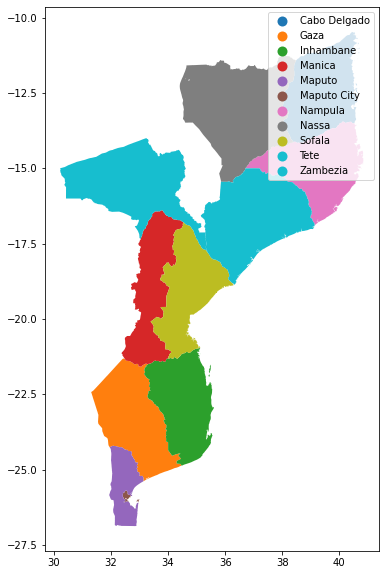

In [441]:
shapefile_Mozam_data1.plot(column='NAME_1', cmap=None, legend=True, figsize=(10, 10))

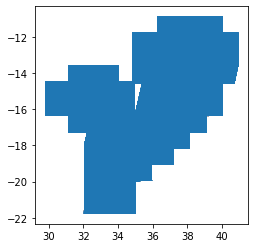

In [442]:
res_df = api.to_geodataframe(products)
res_df.plot();

We can use plot method with sentinelsat to see where the image boundaries lie.

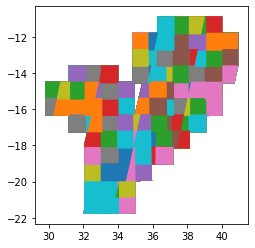

In [443]:
res_df = api.to_geodataframe(products)
res_df.plot(column='uuid', cmap=None);

C:\Users\ENGELB~1\AppData\Local\Temp/ipykernel_9928/3139006325.py:5: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  res_df.apply(lambda x: ax.annotate(s=x.uuid, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);


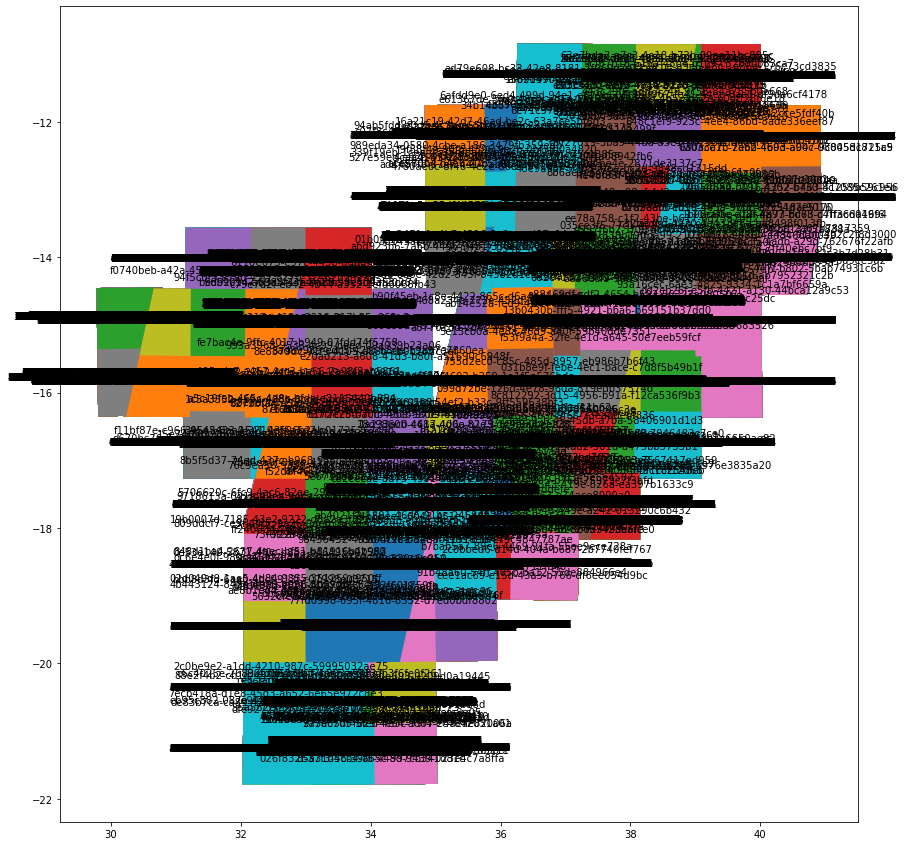

In [444]:
# Label the polygon
# We want to found the intersection over all the products

ax = res_df.plot(column='uuid', cmap=None, figsize=(15, 15))
res_df.apply(lambda x: ax.annotate(s=x.uuid, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);

We think it is difficult to found the intersection over all those products when we have a lot of products. Now what we are trying to do is to check if the product is available online or not. In the case where the products is available online, I can choose one of them or download all the available products.

In [ ]:
print(f"The number of products are : {len(products_gdf['uuid'])}")

In [446]:
a = api.get_product_odata(products_gdf['uuid'][1])

In [447]:
a

{'id': '125e6e43-1eb1-4c8c-82d2-69078e9b532a',
 'title': 'S2B_MSIL2A_20210429T075609_N0300_R035_T36LTJ_20210429T104236',
 'size': 438219191,
 'md5': '881832c4ec016182c1195d60eeaf641f',
 'date': datetime.datetime(2021, 4, 29, 7, 56, 9, 24000),
 'footprint': 'POLYGON((30.666091975856666 -14.460170670895785,30.65990436952227 -14.48805115586486,30.6267642593276 -14.6365116997374,30.59337435373701 -14.784882448021456,30.560652314291737 -14.933342073730676,30.5273503426523 -15.081549694931224,30.49412561147119 -15.229777906164967,30.46108533874648 -15.378067410564238,30.444949124865882 -15.449861272521686,30.204369625659005 -15.447381245067088,30.217189796970526 -14.455833273682469,30.666091975856666 -14.460170670895785))',
 'url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('125e6e43-1eb1-4c8c-82d2-69078e9b532a')/$value",
 'Online': False,
 'Creation Date': datetime.datetime(2021, 4, 29, 13, 49, 25, 307000),
 'Ingestion Date': datetime.datetime(2021, 4, 29, 13, 48, 57, 180000),
 'q

## Downloading data

In [145]:
# This function take as input a path for the geoson file, started and ended date for the tobacco crop,
# print the number of ID products, check if the products ID is available online,
# print he number of products ID available online, download the data for a random particular ID

def Download_Random_ProductID_Sentinel2_Data(path_geojson_file, start_date, end_date):
    
    cpt = 0
    lis_of_index_products_online = []
    
    # Search by polygon
    footprint = geojson_to_wkt(read_geojson(path_geojson_file))
    
    # Searching products
    products = api.query(footprint,
                     date = (start_date, end_date),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = cloudcoverpercentage
                    )
    
    # Convert the result into pandas
    products_gdf = api.to_geodataframe(products)
    
    # Print the number of the products ID
    print(f"The number of products are : {len(products_gdf['uuid'])}")
    
    # go over the number of products
    for i in range(len(products_gdf['uuid'])):
        
        # get each ID products which is a dictionnary
        product_id = api.get_product_odata(products_gdf['uuid'][i])
        
        # go over the keys and get the values
        for j in product_id.keys():
            if (j == 'Online' and product_id[j] == True):
                
                # put the index of product available online  in the list
                lis_of_index_products_online.append(i)
                    
                # print the index and ID of available product online
                print(f"For the index = {i} , the product with ID = {products_gdf['uuid'][i]} is online")
            
                # count the number of product available online
                cpt += 1
    
    # print the list of the index available products online
    print()
    print(f"The list of the available index product online is : {lis_of_index_products_online}")
    print('----'*10)
    print()
    print(f"The number of available products online are : {cpt}")
    
    # check if the list is empty
    if len(lis_of_index_products_online) == 0:
        
        raise ValueError("You can't proceed to the download now because there is no product available online at the moment.")
    
    else:
        
        # Downloading for a particular ID randomly from the list of index
        choice_index_product_random = random.choice(lis_of_index_products_online)
        api.download(products_gdf['uuid'][choice_index_product_random])

In [146]:
# This function take as input a path for the geoson file, started and ended date for the tobacco crop,
# print the number of ID products, check if the products ID is available online,
# print he number of products ID available online, download all the data for all available ID

def Download_All_ProductID_Sentinel2_Data(path_geojson_file, start_date, end_date):
    
    cpt = 0
    lis_of_index_products_online = []
    
    # Search by polygon
    footprint = geojson_to_wkt(read_geojson(path_geojson_file))
    
    # Searching products
    products = api.query(footprint,
                     date = (start_date, end_date),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = cloudcoverpercentage
                    )
    
    # Convert the result into pandas
    products_gdf = api.to_geodataframe(products)
    
    # Print the number of the products ID
    print(f"The number of products are : {len(products_gdf['uuid'])}")
    
    # go over the number of products
    for i in range(len(products_gdf['uuid'])):
        
        # get each ID products which is a dictionnary
        product_id = api.get_product_odata(products_gdf['uuid'][i])
        
        # go over the keys and get the values
        for j in product_id.keys():
            if (j == 'Online' and product_id[j] == True):
                
                # put the index of product available online  in the list
                lis_of_index_products_online.append(i)
                    
                # print the index and ID of available product online
                print(f"For the index = {i} , the product with ID = {products_gdf['uuid'][i]} is online")
            
                # count the number of product available online
                cpt += 1
    
    # print the list of the index available products online
    print()
    print(f"The list of the available index product online is : {lis_of_index_products_online}")
    print('----'*10)
    print()
    print(f"The number of available products online are : {cpt}")
    
    for k in range(len(lis_of_index_products_online)):
    
        # check if the list is empty
        if len(lis_of_index_products_online) == 0:

            raise ValueError("You can't proceed to the download now because there is no product available online at the moment.")

        else:

            # Downloading all the available product from the list of index
            api.download(products_gdf['uuid'][k])

In [147]:
path_geojson_file = "C:/Users/engelbert/Downloads/Ishango/Notebook/mapMozambique.geojson"
start_date = '20200901'
end_date = '20200930'
cloudcoverpercentage = (0,60)


# # Download a particular random products
# Download_Random_ProductID_Sentinel2_Data(path_geojson_file, start_date, end_date)

# Download all the available products
Download_All_ProductID_Sentinel2_Data(path_geojson_file, start_date, end_date)

Querying products:  16%|#6        | 100/617 [00:00<?, ?product/s]

The number of products are : 617


ServerError: HTTP status 500 Internal Server Error: Could not roll back Hibernate transaction; nested exception is org.hibernate.TransactionException: Unable to rollback against JDBC Connection

In [ ]:
# # Downloading for all the products

# api.download_all(products) 

## Unzip sentinel 2 data

In [465]:
path_to_zip = './S2A_MSIL2A_20201109T074131_N0214_R092_T36LYM_20201109T101027.zip'
path_to_extract_to = './'

with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
    zip_ref.extractall(path_to_extract_to)

# Create RGB Image

The true color of satellite images is often displayed in a combination of the red, green and blue bands. Let us first read the data with Rasterio and create an RGB image from Bands 4, 3, and 2.

Our sensor is capable of capturing for different multispectral bands including **red, green, blue** and **near-infrared (nir)** with resolution of 10 to 60 meters.

In [17]:
# Open Bands 4, 3 and 2 with Rasterio

"""
First, we open an empty RGB.tiff in Rasterio with the same parameters — i.e. width, height, CRS, etc..
— of Band 4 ( You can choose any of the three bands). Then we need to write those bands to the empty RGB image.
"""


path = 'C:/Users/engelbert/Downloads/Ishango/Notebook/S2A_MSIL2A_20201109T074131_N0214_R092_T36LYM_20201109T101027.SAFE/GRANULE/L2A_T36LYM_A028117_20201109T080034/IMG_DATA/R10m/'
band4 = rasterio.open(path+'T36LYM_20201109T074131_B04_10m.jp2') #red
band3 = rasterio.open(path+'T36LYM_20201109T074131_B03_10m.jp2') #green
band2 = rasterio.open(path+'T36LYM_20201109T074131_B02_10m.jp2') #blue


# Create an RGB image 
with rio.open('RGB2.tiff', 'w', driver='Gtiff', width=band4.width, height=band4.height, 
              count=3, crs=band4.crs, transform=band4.transform, dtype=band4.dtypes[0]) as rgb:
    rgb.write(band2.read(1),1) 
    rgb.write(band3.read(1),2) 
    rgb.write(band4.read(1),3) 
    rgb.close()

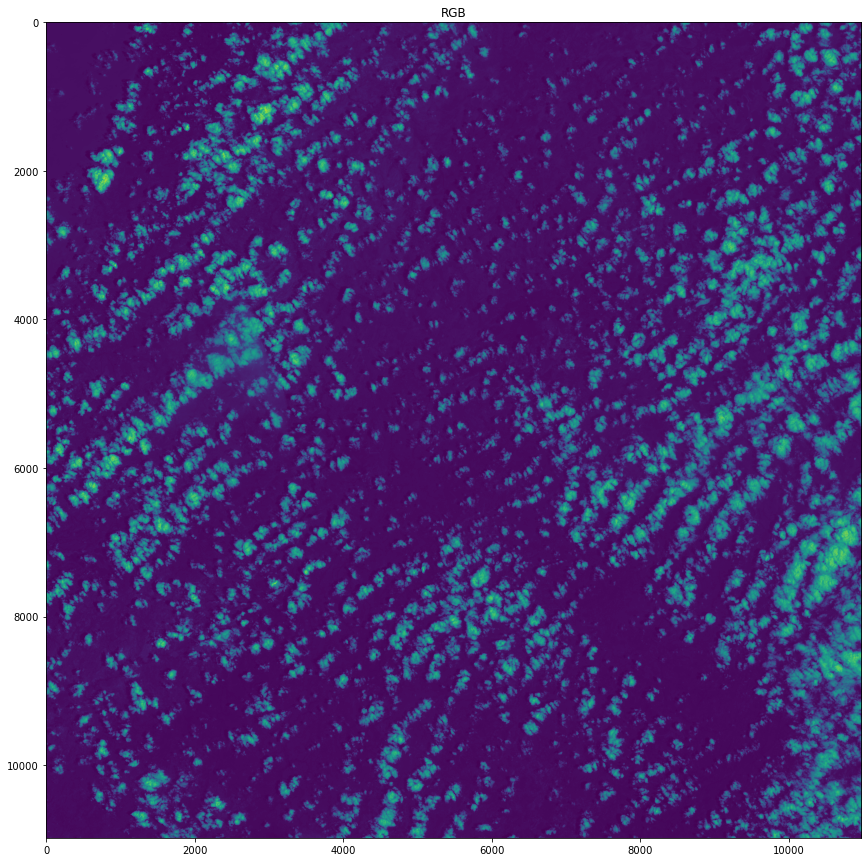

In [19]:
# print the RGB 
image = georaster.SingleBandRaster('C:/Users/engelbert/Downloads/Ishango/Notebook/RGB2.tiff')

plt.figure(figsize = (15,15))
plt.imshow(image.r) 
plt.title('RGB')
plt.show()

In [470]:
type(band2)

rasterio.io.DatasetReader

In [110]:
# import bands as separate 1 band raster

path = 'C:/Users/engelbert/Downloads/Ishango/Notebook/S2A_MSIL2A_20201109T074131_N0214_R092_T36LYM_20201109T101027.SAFE/GRANULE/L2A_T36LYM_A028117_20201109T080034/IMG_DATA/R10m/'

band2 = rasterio.open(path+'T36LYM_20201109T074131_B02_10m.jp2', driver='JP2OpenJPEG') # blue
band3 = rasterio.open(path+'T36LYM_20201109T074131_B03_10m.jp2', driver='JP2OpenJPEG') # green
band4 = rasterio.open(path+'T36LYM_20201109T074131_B04_10m.jp2', driver='JP2OpenJPEG') # red
band8 = rasterio.open(path+'T36LYM_20201109T074131_B08_10m.jp2', driver='JP2OpenJPEG') # nir

In [22]:
# number of raster bands

band8.count

1

In [23]:
# number of raster columns

band8.width

10980

In [24]:
# number of raster rows

band8.height

10980

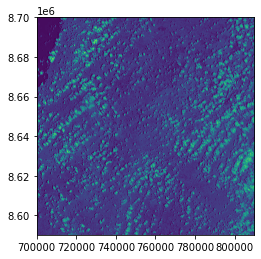

<AxesSubplot:>

In [25]:
# plot band 

plot.show(band8)

In [26]:
type(band8)

rasterio.io.DatasetReader

In [27]:
# type of raster byte

band8.dtypes[0]

'uint16'

In [28]:
# raster sytem of reference

band8.crs

CRS.from_epsg(32736)

In [29]:
# raster transform parameters

band8.transform

Affine(10.0, 0.0, 699960.0,
       0.0, -10.0, 8700040.0)

In [30]:
# raster values as matrix array

band8.read(1)

array([[ 582,  495,  585, ..., 2802, 2542, 2212],
       [ 594,  528,  462, ..., 2822, 2338, 1954],
       [ 499,  447,  543, ..., 2756, 2274, 1788],
       ...,
       [1944, 1854, 1770, ..., 3902, 3746, 3808],
       [1994, 1940, 1832, ..., 3522, 3648, 3862],
       [1904, 1994, 1924, ..., 3746, 3750, 3692]], dtype=uint16)

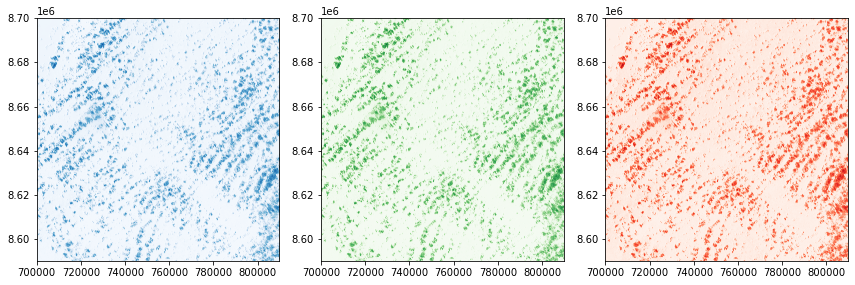

In [31]:
# multiple band representation

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
plot.show(band2, ax=ax1, cmap='Blues')
plot.show(band3, ax=ax2, cmap='Greens')
plot.show(band4, ax=ax3, cmap='Reds')
fig.tight_layout()

# Clip Satellite images

One important preprocessing task to clip or mask an area of study. Since this RGB image is large and huge we save both computing power and time to clip and use only the area of interest. We will clip the shapefile from the RGB image.

In [491]:
"""
Here, we first reproject our shapefile with the same projection as the original image. 
Next, we open the RGB image, get the metadata and mask with the projected boundary.

The result is only the masked/clipped area of interest as shown in the above image.
"""


shapefile_Mozam_data1_proj = shapefile_Mozam_data1.to_crs({'init': 'epsg:32633'})

with rio.open("RGB2.tiff") as src:
    #out_image, out_transform = rio.mask.mask(src, shapefile_data1_proj.geometry, crop=True)
    out_image, out_transform = msk.mask(src, shapefile_Mozam_data1_proj.geometry, invert=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
with rasterio.open("RGB_masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

### Check projection of Imagery and Shapefile in Python

In [492]:
# Check Coordinate Reference System (CRS) of both datasets

print('Shape file Projection: ', shapefile_Mozam_data1.crs)
print('-----------------------------------------')
print('|||||||||||||||||||| Little space |||||||')
print('-----------------------------------------')
print('Imagery file Projection: ', band4.crs)

Shape file Projection:  epsg:4326
-----------------------------------------
|||||||||||||||||||| Little space |||||||
-----------------------------------------
Imagery file Projection:  EPSG:32736


# Create NDVI (Normalized Difference Vegetation Index)

Calculating **NDVI** is an important indicator to assess the presence/absence of green vegetation from the satellite images. To calculate the **NDVI**, you need Red band and Near-Infrared Band **(NIR)**. Different satellite images assign different numbers for these bands. Sentinel Images have red in 4th band and **NIR** in the 8th band. The formula for **NDVI** calculation is:

$$ \mbox{NDVI} = \frac{\mbox{NIR} - \mbox{Red}}{\mbox{NIR} + \mbox{Red}}$$

To carry out this in Rasterio we need first to read the 4th and 8th bands as arrays. We also need to make sure that the arrays are floats.

In [79]:
# Open b4 and b8

path = 'C:/Users/engelbert/Downloads/Ishango/Notebook/S2A_MSIL2A_20201109T074131_N0214_R092_T36LYM_20201109T101027.SAFE/GRANULE/L2A_T36LYM_A028117_20201109T080034/IMG_DATA/R10m/'

band4 = rasterio.open(path+'T36LYM_20201109T074131_B04_10m.jp2')
band8 = rasterio.open(path+'T36LYM_20201109T074131_B08_10m.jp2')


# read Red(b4) and NIR(b8) as arrays
red = band4.read()
nir = band8.read()


# Calculate ndvi = (nir - red)/(nir + red)
ndvi = (nir.astype(float)-red.astype(float))/(nir+red)

# Write the NDVI image
meta = band4.meta
meta.update(driver='GTiff')
meta.update(dtype=rasterio.float32)

with rasterio.open('NDVI2.tif', 'w', **meta) as dst:
    dst.write(ndvi.astype(rasterio.float32))

### Visualize the NDVI file

In [ ]:
# with rio.open('C:/Users/engelbert/Downloads/Ishango/Notebook/NDVI1.tif') as src:
#     dem = src.read()
#     fig, ax = plt.subplots(figsize = (15, 15))
# im = ax.imshow(dem.squeeze())
# ep.colorbar(im)
# ax.set(title="NDVI")
# ax.set_axis_off()
# plt.show()

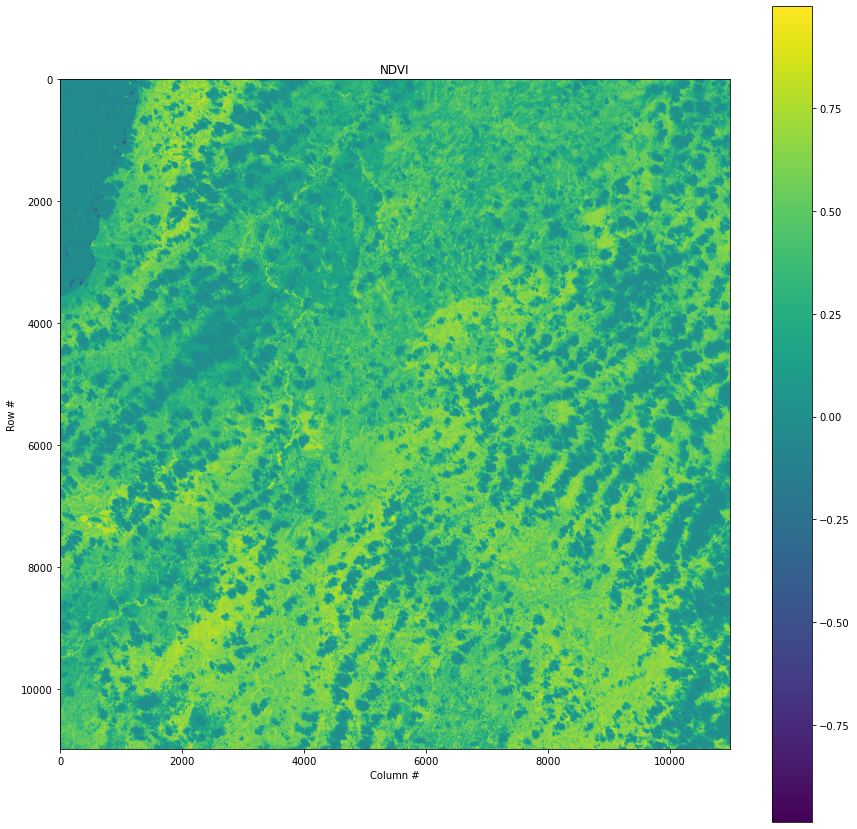

In [495]:
# Use MultiBandRaster() if image has multiple band
image = georaster.SingleBandRaster('C:/Users/engelbert/Downloads/Ishango/Notebook/NDVI2.tif')

# The data of a SingleBandRaster is made available via image.r as a numpy array
# For MultiBandRaster(), image.r gives the raster in [height, width, band] format 
# band no. starts from 0

plt.figure(figsize = (15,15))
plt.imshow(image.r)  # or plt.imshow(image.r[:,:,])
plt.colorbar()
plt.title('NDVI')
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.show()

- The yellow color (NDVI values close to 1.0) indicate that it  can be a forest or crops at maturity.
- The blue color (NDVI values close to -1.0) indicate that it can be  water, snow, built-up areas or barren land.
- The small-blue color (NDVI values close to 0.0) indicate a bare land.
- The yellow-blue color (NDVI values moderate greater than 0.0) indicate the growing plant or urban vegetation.

In [1]:
# """
# Plot NDVI using EarthPy
# """

# titles = ["Sentinel 2 - Normalized Difference Vegetation Index (NDVI)"]

# # Turn off bytescale scaling due to float values for NDVI
# ep.plot_bands(ndvi, cmap="RdYlGn", cols=1, title=titles, vmin=-1, vmax=1)

# Classify NDVI

In [106]:
# Create classes and apply to NDVI results
ndvi_class_bins = [-np.inf, 0, 0.1, 0.25, 0.4, np.inf]
ndvi_sentinel_class = np.digitize(ndvi, ndvi_class_bins)

# Apply the nodata mask to the newly classified NDVI data
ndvi_sentinel_class = np.ma.masked_where(
    np.ma.getmask(ndvi), ndvi_sentinel_class
)
np.unique(ndvi_sentinel_class)

masked_array(data=[1, 2, 3, 4, 5],
             mask=False,
       fill_value=999999,
            dtype=int64)

# Plot classified NDVI with categorical legend using EarthPy

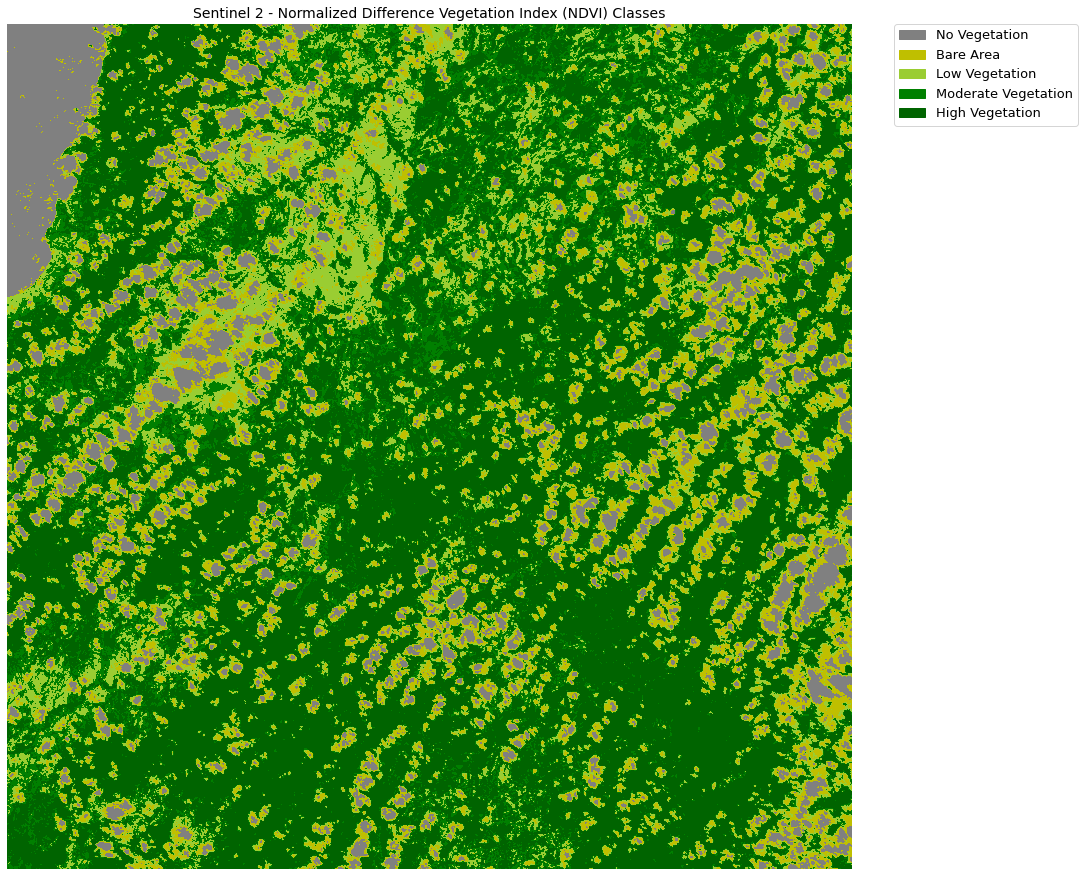

In [104]:
# Define color map
nbr_colors = ["gray", "y", "yellowgreen", "g", "darkgreen"]
nbr_cmap = ListedColormap(nbr_colors)

# Define class names
ndvi_cat_names = [
    "No Vegetation",
    "Bare Area",
    "Low Vegetation",
    "Moderate Vegetation",
    "High Vegetation",
]

# Get list of classes
classes = np.unique(ndvi_sentinel_class)
classes = classes.tolist()
# The mask returns a value of none in the classes. remove that
classes = classes[0:5]

# reshape from (1, 10980, 10980) ----> (10980, 10980)
ndvi_sentinel_class = np.squeeze(ndvi_sentinel_class)

# Plot your data
fig, ax = plt.subplots(figsize=(15, 15))
im = ax.imshow(ndvi_sentinel_class, cmap=nbr_cmap)

ep.draw_legend(im_ax=im, classes=classes, titles=ndvi_cat_names)
ax.set_title(
    "Sentinel 2 - Normalized Difference Vegetation Index (NDVI) Classes",
    fontsize=14,
)
ax.set_axis_off()

# Auto adjust subplot to fit figure size
plt.tight_layout()

# K-means

**Clustering or unsupervised classification** is the process of grouping or aggregating the pixel values of an image into a certain number of natural classes (groups) based on statistical similarity.

We want to try to use the cluster algorithms in Sklearn to classify Sentinel 2 data specifically by looking at a single band 2 of Sentinel 2, which is the blue band and has a spatial resolution of 10m.

In [113]:
# Open the image and read in its meta data 
"""
Meta data give us information about the image such as the data type, size ( width, height), 
counts (number of bands) and coordinate reference system
"""

image_raster = rio.open('C:/Users/engelbert/Downloads/Ishango/Notebook/NDVI1.tif')
print(image_raster.meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32736), 'transform': Affine(10.0, 0.0, 699960.0,
       0.0, -10.0, 8700040.0)}


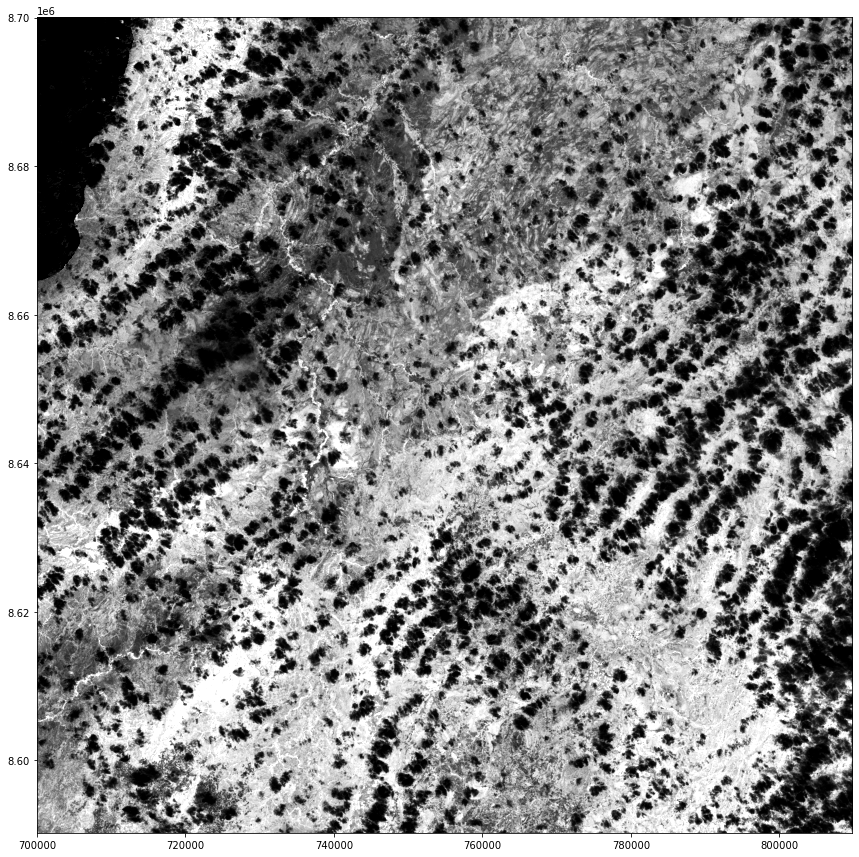

In [114]:
# To visualize this image nicely will need to adjust its contrast first by stretching it out
# Read, enhance and show the image

image_arr = image_raster.read() # read the opened image
vmin, vmax = np.nanpercentile(image_arr, (5,95))  # 5-95% contrast stretch

"""
Image enhancement are used to prepare the "raw data" so that the actual analysis of images will be easier, 
faster and more reliable. The choice of method is dependent on the objective of the analysis
"""

# show the enhanced image
plt.figure(figsize=[15,15])
show(image_raster, cmap='gray', vmin=vmin, vmax=vmax)
plt.show()

In [115]:
"""
By taking the shape of this image we will see it has the order of (bands, height, width), 
this needs to be changed first to the shape order (height, width, bands)
"""

# Creating an empty array using our image size, counts and data type from the meta data

imgxyb = np.empty((image_raster.height, image_raster.width, image_raster.count), image_raster.meta['dtype'])

# loop through the raster's bands to fill the empty array

for band in range(imgxyb.shape[2]):
    imgxyb[:,:,band] = image_raster.read(band+1)

In [116]:
print(f"The changing shape order (height, width, bands) of this image is : {imgxyb.shape}")

The changing shape order (height, width, bands) of this image is : (10980, 10980, 1)


In [117]:
"""
To train our classifier,  we need to convert our x (width) and y (height) dimensions 
to 1 dimension, so to have a 2d array instead of 3d
"""

# convert to 1d array instead to 3d

img1d = imgxyb[:,:,:3].reshape((imgxyb.shape[0] * imgxyb.shape[1], imgxyb.shape[2]))

In [118]:
print(f"The shape of this image in 1d is : {img1d.shape}")

The shape of this image in 1d is : (120560400, 1)


In [119]:
"""
Training
"""

clust = cluster.KMeans(n_clusters=4) # create an object of the classifier
param = clust.fit(img1d) # train it
img_clust = clust.labels_ # get the labels of the classes
img_clust = img_clust.reshape(imgxyb[:,:,0].shape) # reshape labels to a 3d array (one band only)

In [120]:
clust.labels_

array([0, 0, 0, ..., 3, 3, 3])

In [121]:
img_clust.shape

(10980, 10980)

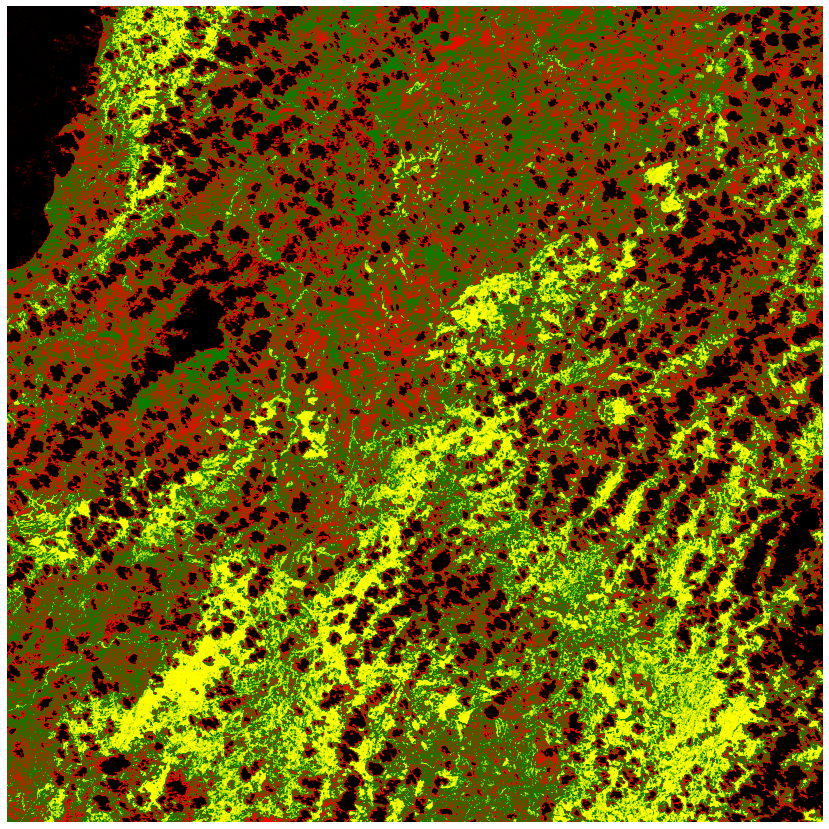

In [122]:
"""
To show the resulting image, we will keep the outsides region as 
black and use red, green and yellow for the rest of the classes
"""

# Create a custom color map to represent our different 4 classes

cmap = mc.LinearSegmentedColormap.from_list("", ["black","red","green","yellow"])

# Show the resulting array and save it as jpg image

plt.figure(figsize=[15,15])
plt.imshow(img_clust, cmap=cmap)
plt.axis('off')
plt.savefig("sent2_clustered1.jpg", bbox_inches='tight')
plt.show()

In [123]:
"""
Prediction

For prediction, all the prepossessing that we have done to the previous image 
(reforming the shape and reshaping to a 2d array) need to be done before we can feed it to the classifier
"""

# open the raster image
img_for_pred = rio.open('C:/Users/engelbert/Downloads/Ishango/Notebook/TestCluster/NDVI_test.tif')

# create an empty array with same dimensions and data type 
img_for_pred_xyb = np.empty((img_for_pred.height, img_for_pred.width,img_for_pred.count), img_for_pred.meta['dtype'])

# loop through the raster bands and fill the empty array in x-y-bands order
for band in range(img_for_pred_xyb.shape[2]):
    img_for_pred_xyb[:,:,band] = img_for_pred.read(band+1)
    
# convert to 1d array
img_for_pred_1d = img_for_pred_xyb[:,:,:3].reshape(img_for_pred_xyb.shape[0]*img_for_pred_xyb.shape[1], img_for_pred_xyb.shape[2])

# predict the clusters in the image 
pred = clust.predict(img_for_pred_1d)

# reshape the 1d array predictions to x-y-bands shape order (only one band)
img_for_pred_cul = pred
img_for_pred_cul = img_for_pred_cul.reshape(img_for_pred_xyb[:,:,0].shape)

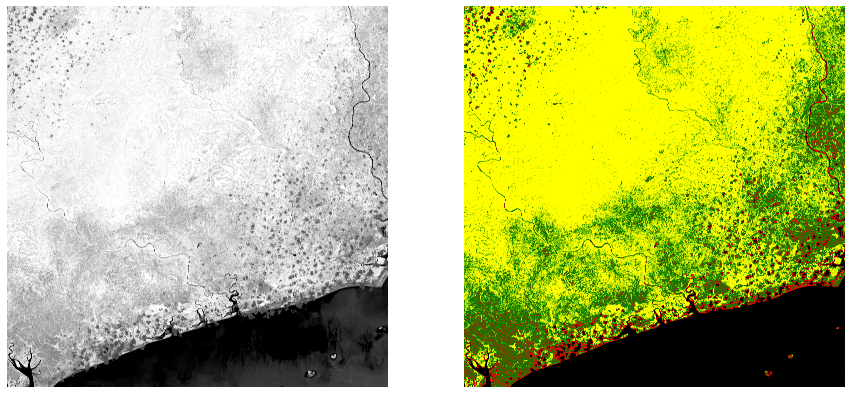

In [124]:
"""
Show the original and the resulting predicted image in a subplot. 
First, we will enhance the original image for better viewing through contrast stretch
"""

img_for_pred_arr = img_for_pred.read() # Read the image
vmin, vmax = np.nanpercentile(img_for_pred_arr, (5,95)) # 5–95% contrast stretch

# show the original and predicted image
fig, (ax1,ax2) = plt.subplots(figsize=[15,15], nrows=1, ncols=2, sharey=False,)
show(img_for_pred, cmap='gray', vmin=vmin, vmax=vmax, ax=ax1)
show(img_for_pred_cul, cmap=cmap, ax=ax2)
ax1.set_axis_off()
ax2.set_axis_off()
fig.savefig("sent2_pred1.png", bbox_inches='tight')
plt.show()

We can noticed that these clusters provides us information about where associations and patterns in band exist. But they does not tell us what those clusters mean.

# Some explorations

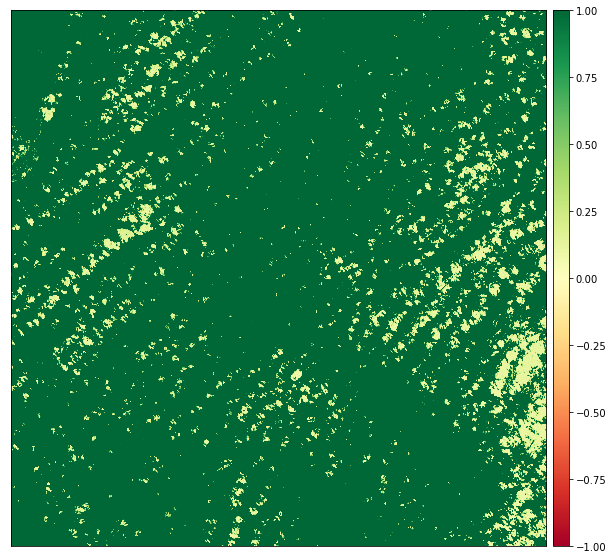

<AxesSubplot:>

In [65]:
"""
Visible Atmospherically Resistant Index (VARI), emphasis on vegetation while mitigating atmospheric and illumination effects.
"""
# vari = (green - red)/(green + red - blue)

blue = band2.read()    # pixel value of blue channel
red = band4.read()     # pixel value of red channel
green = band3.read()   # pixel value of green channel


vari = (green - red)/(green + red - blue)
ep.plot_bands(vari, cmap="RdYlGn", cols=1, vmin=-1, vmax=1, figsize=(10,10))